#Setting up


Importing necessary standard libraries and tensorflow functional APIs

In [1]:
#standard libraries
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import zipfile

In [2]:
#tensorflow dependencies
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten, Dropout
import tensorflow as tf


Configuring GPU

In [3]:
gpus=tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
for gpu in gpus:
    print(gpu)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


# Loading and Preprocessing images

In [4]:
#EXTRACTING FROM ZIP FILES
zip_path = "anchor_faces.zip"
extract_path = "./anchors"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Check files
os.listdir(extract_path)

['anchor_faces']

In [5]:
zip_path = "positive_faces.zip"
extract_path = "./positives"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Check files
os.listdir(extract_path)

['positive_faces', '__MACOSX']

In [6]:
zip_path = "negative_faces.zip"
extract_path = "./negatives"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Check files
os.listdir(extract_path)

['__MACOSX', 'negative_faces']

In [7]:
#SETTING UP PATHS TO DATA FOLDERS
POS_PATH=os.path.join('./positives/positive_faces')
NEG_PATH=os.path.join('./negatives/negative_faces')
ANC_PATH=os.path.join('./anchors/anchor_faces')

In [8]:
#GET IMAGE FILES FROM EACH OF THESE DIRECTORIES
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(2028)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(2028)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(2028)

## Creating triplet dataset

In [9]:
#ZIP THEM TOGETHER
data_triplets = tf.data.Dataset.zip((anchor, positive,negative))

In [10]:
#PREPROCESSING:SCALING AND RESIZING

def preprocess(file_path):
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img, (100,100))
    img = img / 255.0
    return img

def preprocess_triplet(anchor_path, positive_path, negative_path):
    return (preprocess(anchor_path), preprocess(positive_path), preprocess(negative_path))


In [11]:
data_triplets = data_triplets.map(preprocess_triplet, num_parallel_calls=tf.data.AUTOTUNE)
data_triplets.cache()
data_triplets=data_triplets.shuffle(buffer_size=1024)

In [12]:
#SPLITTING IN TRAIN AND TEST SETS
train_data=data_triplets.take(round(len(data_triplets)*0.7))
train_data=train_data.batch(32)
train_data=train_data.prefetch(tf.data.AUTOTUNE)

test_data=data_triplets.skip(round(len(data_triplets)*0.7))
test_data=test_data.take(round(len(data_triplets)*0.3))
test_data=test_data.batch(16)
test_data=test_data.prefetch(tf.data.AUTOTUNE)


# Creating the Neural Network Model

In [13]:
#BUILDING THE EMBEDDING ARCHITECTURE

#convolution and max pooling layers, used to encode the raw image inputs, as specified in the Siamese neural networks resesarch paper
def make_embedding():
    inp = Input(shape=(100,100,3))

    #first block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

    #second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    c2 = Dropout(0.2)(c2)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

    #third block
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

    #final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)

    return Model(inputs=inp, outputs=d1)

In [14]:
embedding_model=make_embedding()

In [15]:
embedding_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 40, 40, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

# Training

### Triplet Loss

In [16]:
margin = 0.55

def triplet_loss(anchor, positive, negative):
    pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=1)
    neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=1)
    basic_loss = pos_dist - neg_dist + margin
    loss = tf.reduce_mean(tf.maximum(basic_loss, 0.0))
    return loss

In [17]:
optimizer = tf.keras.optimizers.Adam(1e-4)

In [18]:
#TRAINING FUNCTION FOR ONE BATCH
@tf.function
def train_step(anchor, positive, negative):
    with tf.GradientTape() as tape:
        anchor_emb = embedding_model(anchor, training=True)
        positive_emb = embedding_model(positive, training=True)
        negative_emb = embedding_model(negative, training=True)

        loss = triplet_loss(anchor_emb, positive_emb, negative_emb)

    gradients = tape.gradient(loss, embedding_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, embedding_model.trainable_variables))
    return loss

In [19]:
#COMPLETE TRAINING FUNCTION
def train_model(epochs):
    loss_history = []

    for epoch in range(1, epochs+1):
        epoch_loss = []
        print(f"Epoch {epoch}/{epochs}")
        for batch in train_data:
            anc, pos, neg = batch
            loss = train_step(anc, pos, neg)
            epoch_loss.append(loss.numpy())

        mean_loss = np.mean(epoch_loss)
        loss_history.append(mean_loss)
        print(f"Loss: {mean_loss:.4f}")

    return loss_history

Epoch 1/26
Loss: 0.1501
Epoch 2/26
Loss: 0.0568
Epoch 3/26
Loss: 0.0184
Epoch 4/26
Loss: 0.0225
Epoch 5/26
Loss: 0.0167
Epoch 6/26
Loss: 0.0148
Epoch 7/26
Loss: 0.0278
Epoch 8/26
Loss: 0.0153
Epoch 9/26
Loss: 0.0255
Epoch 10/26
Loss: 0.0336
Epoch 11/26
Loss: 0.0238
Epoch 12/26
Loss: 0.0132
Epoch 13/26
Loss: 0.0178
Epoch 14/26
Loss: 0.0168
Epoch 15/26
Loss: 0.0083
Epoch 16/26
Loss: 0.0129
Epoch 17/26
Loss: 0.0188
Epoch 18/26
Loss: 0.0322
Epoch 19/26
Loss: 0.0283
Epoch 20/26
Loss: 0.0082
Epoch 21/26
Loss: 0.0154
Epoch 22/26
Loss: 0.0204
Epoch 23/26
Loss: 0.0144
Epoch 24/26
Loss: 0.0101
Epoch 25/26
Loss: 0.0149
Epoch 26/26
Loss: 0.0063


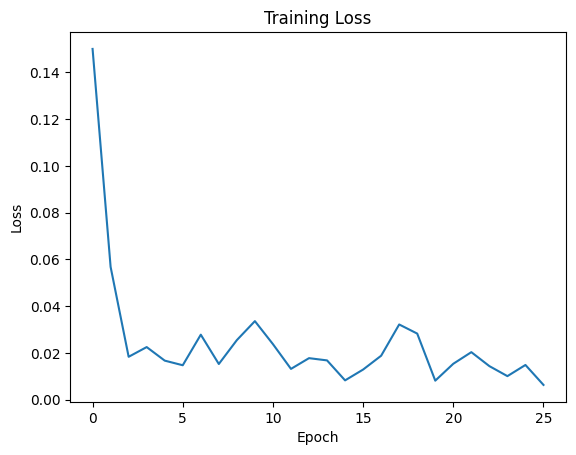

In [20]:
#TRAINING
loss_history = train_model(epochs=26)

# Plot loss curve
plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()


#Testing the model


In [21]:
# Import metric calculations
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [30]:
#loading previously trained model for testing
embedding_model = tf.keras.models.load_model('embedding_model.keras')

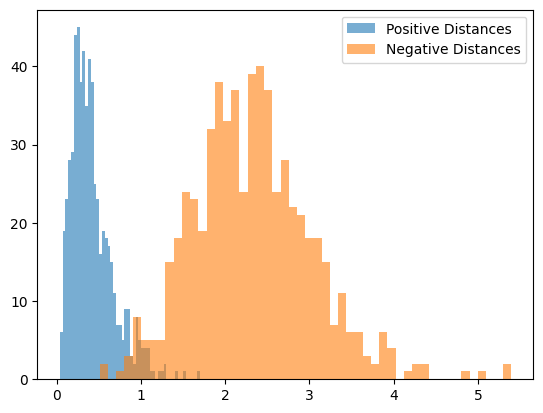

In [31]:
#TUNING THE THRESHOLD BY VISUALIZING THE POSITIVE AND NEGATIVE DISTANCES
pos_dists = []
neg_dists = []

for batch in test_data:
    anc, pos, neg = batch
    anc_emb = embedding_model(anc)
    pos_emb = embedding_model(pos)
    neg_emb = embedding_model(neg)

    pos_dist = tf.norm(anc_emb - pos_emb, axis=1)
    neg_dist = tf.norm(anc_emb - neg_emb, axis=1)

    pos_dists.extend(pos_dist.numpy())
    neg_dists.extend(neg_dist.numpy())

plt.hist(pos_dists, bins=50, label="Positive Distances", alpha=0.6)
plt.hist(neg_dists, bins=50, label="Negative Distances", alpha=0.6)
plt.legend()
plt.show()


In [36]:
#TESTING FUNCTION
def test_model(test_data, threshold=0.5):
    y_true = []
    y_pred = []

    for batch in test_data:
        anc, pos, neg = batch

        anc_emb = embedding_model(anc)
        pos_emb = embedding_model(pos)
        neg_emb = embedding_model(neg)

        # Positive pair distances
        pos_dist = tf.norm(anc_emb - pos_emb, axis=1)
        pos_pred = pos_dist < threshold

        y_true.extend([1]*len(pos_pred))
        y_pred.extend(pos_pred.numpy())

        # Negative pair distances
        neg_dist = tf.norm(anc_emb - neg_emb, axis=1)
        neg_pred = neg_dist < threshold

        y_true.extend([0]*len(neg_pred))
        y_pred.extend(neg_pred.numpy())

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")

test_model(test_data, threshold=0.8)


Accuracy: 0.9515
Precision: 0.9893
Recall: 0.9128
F1 Score: 0.9495


Saving the model

In [24]:
embedding_model.save('embedding_model_1.keras')